In [1]:
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

In [2]:
# Load the dataset
data = pd.read_csv('../../../csv/Beras.csv')

data.head(), data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 678 entries, 0 to 677
Data columns (total 11 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Tanggal                   678 non-null    object
 1   Luas Panen Padi           678 non-null    int64 
 2   GKP Tingkat Petani        678 non-null    int64 
 3   GKP Tingkat Penggilingan  678 non-null    int64 
 4   GKG Tingkat Penggilingan  678 non-null    int64 
 5   Harga Beras Penggilingan  678 non-null    int64 
 6   Produksi Beras            678 non-null    int64 
 7   Harga Beras               678 non-null    int64 
 8   UMP                       678 non-null    int64 
 9   BBM Solar                 678 non-null    int64 
 10  Tingkat Konsumsi          678 non-null    int64 
dtypes: int64(10), object(1)
memory usage: 58.4+ KB


(      Tanggal  Luas Panen Padi  GKP Tingkat Petani  GKP Tingkat Penggilingan  \
 0  2021-03-15               10                4000                      4150   
 1  2021-03-16               10                3850                      4100   
 2  2021-03-17               10                4160                      4230   
 3  2021-03-18               10                4120                      4190   
 4  2021-03-19               10                4190                      4290   
 
    GKG Tingkat Penggilingan  Harga Beras Penggilingan  Produksi Beras  \
 0                      5050                      9465           14419   
 1                      4740                      9360           14419   
 2                      4950                      9400           14419   
 3                      4730                      9340           14419   
 4                      4990                      9410           14419   
 
    Harga Beras   UMP  BBM Solar  Tingkat Konsumsi  
 0        112

In [3]:
data['Tanggal'] = pd.to_datetime(data['Tanggal'])
data['Year'] = data['Tanggal'].dt.year
data['Month'] = data['Tanggal'].dt.month

In [4]:
data_mod = data.drop(columns=['Tanggal'])

X = data_mod['Luas Panen Padi']
y = data_mod['Harga Beras']

In [5]:
# Decompose the train and test data with a specified period of 7 days for weekly seasonality
decomposition_train = sm.tsa.seasonal_decompose(X, model='additive', period=12)
decomposition_test = sm.tsa.seasonal_decompose(y, model='additive', period=12)

# Collect the components for train data
train_trend = decomposition_train.trend.dropna()
train_seasonal = decomposition_train.seasonal.dropna()
train_residual = decomposition_train.resid.dropna()

# Collect the components for test data
test_trend = decomposition_test.trend.dropna()
test_seasonal = decomposition_test.seasonal.dropna()
test_residual = decomposition_test.resid.dropna()

# Display the components for train data
train_trend.head(), train_seasonal.head(), train_residual.head()

(6     29.166667
 7     32.500000
 8     36.250000
 9     40.416667
 10    44.583333
 Name: trend, dtype: float64,
 0   -0.426779
 1    1.952009
 2    1.073221
 3    0.747463
 4   -1.010112
 Name: seasonal, dtype: float64,
 6     -8.828497
 7      9.467634
 8      3.068824
 9      8.931920
 10    24.259301
 Name: resid, dtype: float64)

# Residual

In [6]:
cutoff_index = int(len(data_mod) * 0.8)

# Split the dataset into training and testing sets using the calculated index
X_train_residual = train_residual.iloc[:cutoff_index]
X_test_residual = train_residual.iloc[cutoff_index:]
y_train_residual = test_residual.iloc[:cutoff_index]
y_test_residual = test_residual.iloc[cutoff_index:]

In [7]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid for Random Forest
param_grid = {
    'n_estimators': [50, 100, 200],  # Number of trees in the forest
    'max_depth': [None, 10, 20, 30],  # Maximum depth of the tree
    'min_samples_split': [2, 10, 20]  # Minimum number of samples required to split an internal node
}

# Initialize the RandomForestRegressor
rf = RandomForestRegressor(random_state=42)

# Setup GridSearchCV
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', verbose=1)

# Reshape X_train to a 2D array
X_train_residual = X_train_residual.values.reshape(-1, 1)

# Fit GridSearchCV
grid_search.fit(X_train_residual, y_train_residual)

# Evaluate the best model from grid search
best_rf = grid_search.best_estimator_
best_score = grid_search.best_score_
best_params = grid_search.best_params_

best_rf, best_score, best_params

Fitting 5 folds for each of 36 candidates, totalling 180 fits


(RandomForestRegressor(max_depth=10, min_samples_split=20, random_state=42),
 -1690.048019802589,
 {'max_depth': 10, 'min_samples_split': 20, 'n_estimators': 100})

Mean Squared Error: 1710.351987241689


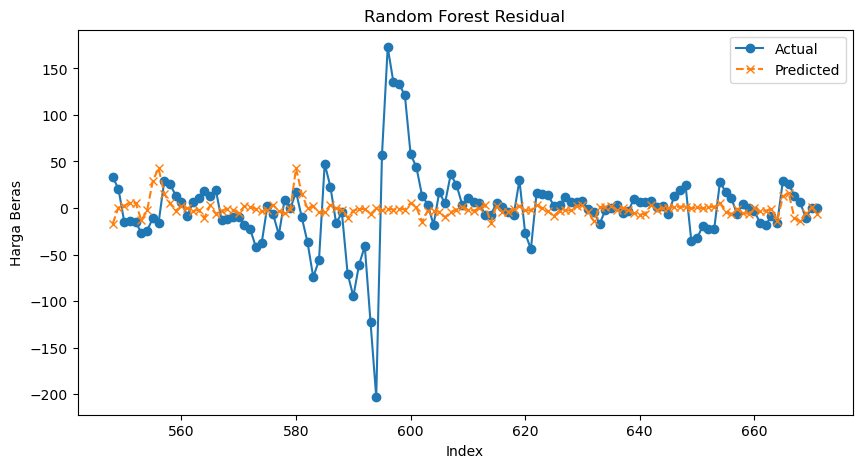

In [8]:
# Save the original index
original_index = X_test_residual.index

# Convert X_test to a numpy array and reshape it to a 2D array
X_testreshape = X_test_residual.values.reshape(-1, 1)

# Make predictions on the testing data using the best Random Forest model
predictions_residual = best_rf.predict(X_testreshape)

# Evaluate the model
mse = mean_squared_error(y_test_residual, predictions_residual)

print('Mean Squared Error:', mse)

# Optionally, visualize the actual and predicted values
plt.figure(figsize=(10, 5))
# Use the original index in the plot
plt.plot(original_index, y_test_residual, label='Actual', marker='o')
plt.plot(original_index, predictions_residual, label='Predicted', linestyle='--', marker='x')
plt.xlabel('Index')
plt.ylabel('Harga Beras')
plt.title('Random Forest Residual')
plt.legend()
plt.show()

# Seasonal

In [9]:
cutoff_index = int(len(data_mod) * 0.8)

# Split the dataset into training and testing sets using the calculated index
X_train_seasonal = train_seasonal.iloc[:cutoff_index]
X_test_seasonal = train_seasonal.iloc[cutoff_index:]
y_train_seasonal = test_seasonal.iloc[:cutoff_index]
y_test_seasonal = test_seasonal.iloc[cutoff_index:]

In [10]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid for Random Forest
param_grid = {
    'n_estimators': [50, 100, 200],  # Number of trees in the forest
    'max_depth': [None, 10, 20, 30],  # Maximum depth of the tree
    'min_samples_split': [2, 10, 20]  # Minimum number of samples required to split an internal node
}

# Initialize the RandomForestRegressor
rf = RandomForestRegressor(random_state=42)

# Setup GridSearchCV
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', verbose=1)

# Reshape X_train to a 2D array
X_train_seasonal = X_train_seasonal.values.reshape(-1, 1)

# Fit GridSearchCV
grid_search.fit(X_train_seasonal, y_train_seasonal)

# Evaluate the best model from grid search
best_rf = grid_search.best_estimator_
best_score = grid_search.best_score_
best_params = grid_search.best_params_

best_rf, best_score, best_params

Fitting 5 folds for each of 36 candidates, totalling 180 fits


(RandomForestRegressor(n_estimators=50, random_state=42),
 -2.6351572862387403e-29,
 {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 50})

Mean Squared Error: 3.0743823624247555e-29


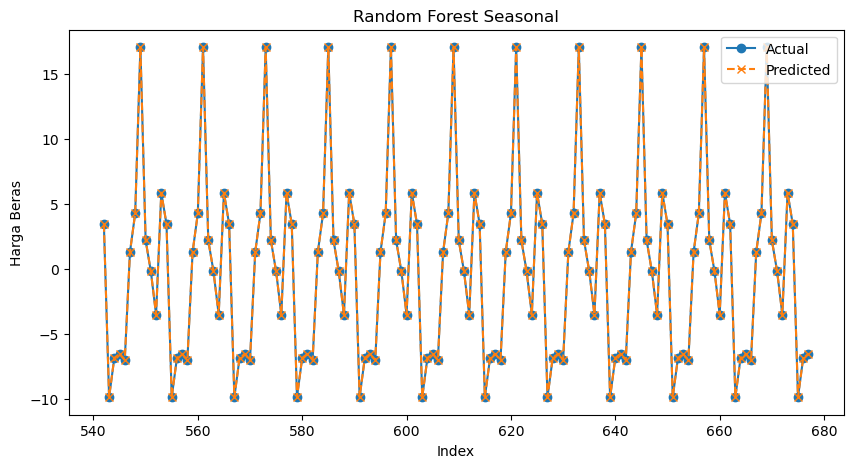

In [11]:
# Save the original index
original_index = X_test_seasonal.index

# Convert X_test to a numpy array and reshape it to a 2D array
X_testreshape = X_test_seasonal.values.reshape(-1, 1)

# Make predictions on the testing data using the best Random Forest model
predictions_seasonal = best_rf.predict(X_testreshape)

# Evaluate the model
mse = mean_squared_error(y_test_seasonal, predictions_seasonal)

print('Mean Squared Error:', mse)

# Optionally, visualize the actual and predicted values
plt.figure(figsize=(10, 5))
# Use the original index in the plot
plt.plot(original_index, y_test_seasonal, label='Actual', marker='o')
plt.plot(original_index, predictions_seasonal, label='Predicted', linestyle='--', marker='x')
plt.xlabel('Index')
plt.ylabel('Harga Beras')
plt.title('Random Forest Seasonal')
plt.legend()
plt.show()

# Trend

In [12]:
cutoff_index = int(len(data_mod) * 0.8)

# Split the dataset into training and testing sets using the calculated index
X_train_trend = train_trend.iloc[:cutoff_index]
X_test_trend = train_trend.iloc[cutoff_index:]
y_train_trend = test_trend.iloc[:cutoff_index]
y_test_trend = test_trend.iloc[cutoff_index:]

In [13]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid for Random Forest
param_grid = {
    'n_estimators': [50, 100, 200],  # Number of trees in the forest
    'max_depth': [None, 10, 20, 30],  # Maximum depth of the tree
    'min_samples_split': [2, 10, 20]  # Minimum number of samples required to split an internal node
}

# Initialize the RandomForestRegressor
rf = RandomForestRegressor(random_state=42)

# Setup GridSearchCV
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', verbose=1)

# Reshape X_train to a 2D array
X_train_trend = X_train_trend.values.reshape(-1, 1)

# Fit GridSearchCV
grid_search.fit(X_train_trend, y_train_trend)

# Evaluate the best model from grid search
best_rf = grid_search.best_estimator_
best_score = grid_search.best_score_
best_params = grid_search.best_params_

best_rf, best_score, best_params

Fitting 5 folds for each of 36 candidates, totalling 180 fits


(RandomForestRegressor(max_depth=10, min_samples_split=20, n_estimators=50,
                       random_state=42),
 -386491.89652076236,
 {'max_depth': 10, 'min_samples_split': 20, 'n_estimators': 50})

Mean Squared Error: 3358263.324575817


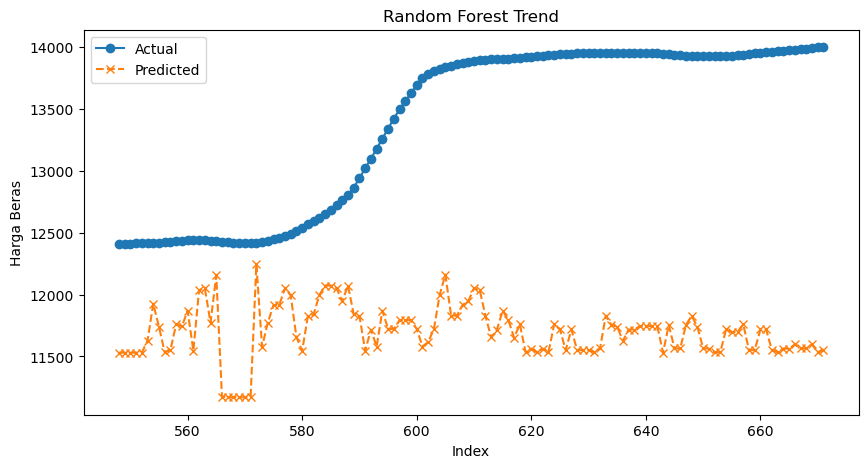

In [14]:
# Save the original index
original_index = X_test_trend.index

# Convert X_test to a numpy array and reshape it to a 2D array
X_testreshape = X_test_trend.values.reshape(-1, 1)

# Make predictions on the testing data using the best Random Forest model
predictions_trend = best_rf.predict(X_testreshape)

# Evaluate the model
mse = mean_squared_error(y_test_trend, predictions_trend)

print('Mean Squared Error:', mse)

# Optionally, visualize the actual and predicted values
plt.figure(figsize=(10, 5))
# Use the original index in the plot
plt.plot(original_index, y_test_trend, label='Actual', marker='o')
plt.plot(original_index, predictions_trend, label='Predicted', linestyle='--', marker='x')
plt.xlabel('Index')
plt.ylabel('Harga Beras')
plt.title('Random Forest Trend')
plt.legend()
plt.show()

In [15]:
# Ensure all arrays have the same length
min_length = min(len(predictions_residual), len(predictions_seasonal), len(predictions_trend))

# Trim the arrays to the minimum length
predictions_residual = predictions_residual[:min_length]
predictions_seasonal = predictions_seasonal[:min_length]
predictions_trend = predictions_trend[:min_length]

# Now you can add them together
predict_result = predictions_residual + predictions_seasonal + predictions_trend
predict_result

array([11516.78516214, 11520.79243673, 11525.78297363, 11529.11239115,
       11528.56375538, 11613.7702894 , 11927.84288055, 11785.78799078,
       11579.18757241, 11565.71528262, 11761.74495957, 11745.42736845,
       11875.04133355, 11535.26662889, 12025.94548468, 12042.40603535,
       11754.74987731, 12158.45545168, 11173.19108241, 11184.07138367,
       11171.37641168, 11167.34426545, 11161.04910685, 11182.5594059 ,
       12248.28713121, 11567.38147441, 11761.98115005, 11907.12281433,
       11911.61235183, 12048.89015701, 11991.46856031, 11670.55590596,
       11590.46199981, 11842.02177154, 11835.21907455, 12004.30598412,
       12071.53600196, 12058.20266863, 12047.67628286, 11940.00522841,
       12063.70187372, 11830.34157546, 11828.40703356, 11561.56993686,
       11717.20032649, 11573.03259589, 11865.78224971, 11725.78809627,
       11725.30559078, 11781.76964572, 11785.98401112, 11785.06882187,
       11720.84117797, 11582.26094576, 11605.22368821, 11736.84850181,
      

In [16]:
y_test_result = y_test_residual + y_test_seasonal + y_test_trend
y_test_result

542   NaN
543   NaN
544   NaN
545   NaN
546   NaN
       ..
673   NaN
674   NaN
675   NaN
676   NaN
677   NaN
Length: 136, dtype: float64

In [17]:
import numpy as np

# Remove NaN values from the arrays
predict_result = predict_result[~np.isnan(predict_result)]
y_test_result = y_test_result[~np.isnan(y_test_result)]

# Ensure both arrays have the same length
min_length = min(len(predict_result), len(y_test_result))

# Trim the arrays to the minimum length
predict_result = predict_result[:min_length]
y_test_result = y_test_result[:min_length]

# Now you can calculate the errors
rmse = sqrt(mean_squared_error(predict_result, y_test_result))
mae = mean_absolute_error(predict_result, y_test_result)
mse = mean_squared_error(predict_result, y_test_result)

print("Root Mean Square Error:", rmse)
print("Mean Absolute Error:", mae)
print("Mean Square Error:", mse)

Root Mean Square Error: 1836.6427308885952
Mean Absolute Error: 1688.7310986359914
Mean Square Error: 3373256.520925917
